<a href="https://colab.research.google.com/github/Renzo0o0/VaRHistoric-Andres-Rendon/blob/feature%2Fcvar-es/VaR_CVaR_Feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descargando datos de mercado...


/tmp/ipython-input-2118164448.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  8 of 8 completed


Datos listos.

=== VaR Histórico ===
VaR 95%: -1.8193%
VaR 99%: -3.6880%

=== Expected Shortfall (CVaR) ===
CVaR 95%: -3.1366%
CVaR 99%: -5.7347%



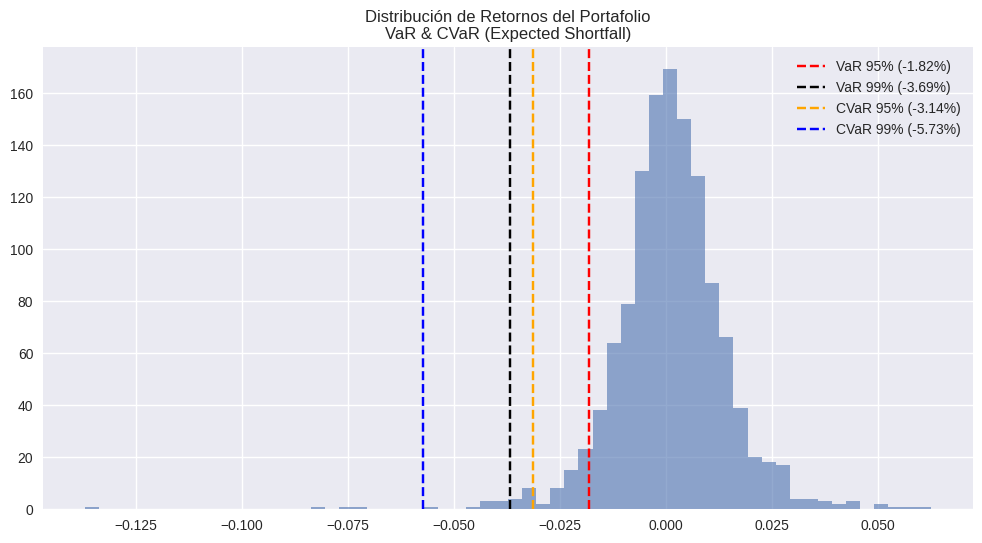

=== ANÁLISIS ===

1. El VaR señala el umbral de pérdida extrema en un día típico, pero no 
   indica la severidad de las pérdidas cuando dicho umbral se supera.

2. El CVaR (Expected Shortfall) complementa al VaR midiendo la pérdida 
   promedio en los peores escenarios. Es un indicador más robusto ante colas 
   pesadas, especialmente en portafolios con crypto, emergentes o commodities.

3. Desde un punto de vista institucional (Market Risk / FRTB), el CVaR es un 
   “coherent risk measure”, a diferencia del VaR, que no siempre cumple 
   subaditividad.

4. Si el CVaR es sustancialmente más negativo que el VaR, implica que:
   - el portafolio sufre eventos extremos severos
   - la cola está cargada (heavy-tailed)
   - conviene revisar exposición a activos volátiles (p. ej., BTC, Oil)

5. El siguiente paso en este branch sería:
   - incorporar backtesting (Kupiec / Christoffersen)
   - estudiar contribución al riesgo por activo (marginal y porcentual)



In [1]:
# ============================================================
# PROJECT: Historical VaR + Expected Shortfall (CVaR)
# BRANCH: feature/cvar-es
# AUTHOR: Andres R. (with quant guidance)
# PURPOSE: Version 2 of the VaR project
# ============================================================

# ============================================================
# 1. SETUP
# ============================================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)

# Portafolio multi-activo
tickers = ["SPY", "EEM", "IEF", "EURUSD=X", "JPY=X", "GC=F", "BZ=F", "BTC-USD"]
weights = np.array([0.25, 0.10, 0.25, 0.10, 0.05, 0.10, 0.05, 0.10])

start = "2019-12-01"
end   = "2024-12-01"

# ============================================================
# 2. DATA
# ============================================================

print("Descargando datos de mercado...")
raw = yf.download(tickers, start=start, end=end)

# Tomamos solo los precios de cierre
prices = raw.xs('Close', level=0, axis=1).dropna()
print("Datos listos.\n")

# Retornos diarios
returns = prices.pct_change().dropna()

# Retorno del portafolio
portfolio_returns = returns.dot(weights)

# ============================================================
# 3. VALUE AT RISK (VaR)
# ============================================================

def historical_var(series, level=0.95):
    """VaR histórico (cuantil empírico)."""
    return np.percentile(series, (1-level)*100)

VaR_95 = historical_var(portfolio_returns, 0.95)
VaR_99 = historical_var(portfolio_returns, 0.99)

print("=== VaR Histórico ===")
print(f"VaR 95%: {VaR_95:.4%}")
print(f"VaR 99%: {VaR_99:.4%}\n")


# ============================================================
# 4. EXPECTED SHORTFALL (CVaR / ES)
# ============================================================

def historical_cvar(series, level=0.95):
    """
    CVaR empírico: pérdida promedio condicional
    a estar por debajo del VaR.
    """
    VaR = np.percentile(series, (1-level)*100)
    tail = series[series <= VaR]

    if len(tail) == 0:
        return np.nan

    return tail.mean()

CVaR_95 = historical_cvar(portfolio_returns, 0.95)
CVaR_99 = historical_cvar(portfolio_returns, 0.99)

print("=== Expected Shortfall (CVaR) ===")
print(f"CVaR 95%: {CVaR_95:.4%}")
print(f"CVaR 99%: {CVaR_99:.4%}\n")


# ============================================================
# 5. VISUALIZACIÓN
# ============================================================

plt.hist(portfolio_returns, bins=60, alpha=0.6)
plt.axvline(VaR_95, color='red', linestyle='--', label=f'VaR 95% ({VaR_95:.2%})')
plt.axvline(VaR_99, color='black', linestyle='--', label=f'VaR 99% ({VaR_99:.2%})')
plt.axvline(CVaR_95, color='orange', linestyle='--', label=f'CVaR 95% ({CVaR_95:.2%})')
plt.axvline(CVaR_99, color='blue', linestyle='--', label=f'CVaR 99% ({CVaR_99:.2%})')
plt.title("Distribución de Retornos del Portafolio\nVaR & CVaR (Expected Shortfall)")
plt.legend()
plt.show()


# ============================================================
# 6. ANÁLISIS INSTITUCIONAL (texto)
# ============================================================

print("=== ANÁLISIS ===")
print("""
1. El VaR señala el umbral de pérdida extrema en un día típico, pero no
   indica la severidad de las pérdidas cuando dicho umbral se supera.

2. El CVaR (Expected Shortfall) complementa al VaR midiendo la pérdida
   promedio en los peores escenarios. Es un indicador más robusto ante colas
   pesadas, especialmente en portafolios con crypto, emergentes o commodities.

3. Desde un punto de vista institucional (Market Risk / FRTB), el CVaR es un
   “coherent risk measure”, a diferencia del VaR, que no siempre cumple
   subaditividad.

4. Si el CVaR es sustancialmente más negativo que el VaR, implica que:
   - el portafolio sufre eventos extremos severos
   - la cola está cargada (heavy-tailed)
   - conviene revisar exposición a activos volátiles (p. ej., BTC, Oil)

5. El siguiente paso en este branch sería:
   - incorporar backtesting (Kupiec / Christoffersen)
   - estudiar contribución al riesgo por activo (marginal y porcentual)
""")
